[[0. 2. 2. 1. 1. 2. 2. 2. 1. 2. 2. 2. 2. 0.]
 [2. 0. 0. 0. 0. 2. 2. 0. 0. 0. 0. 2. 0. 0.]
 [2. 0. 0. 0. 0. 0. 0. 2. 0. 2. 0. 0. 2. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [2. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [2. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [2. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [2. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [2. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [2. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [2. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

Best solution = [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] cost = 29.0


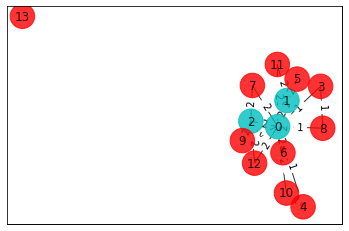

In [16]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Generating a graph of 4 nodes

n=14 # Number of nodes in graph
x=2
G=nx.Graph()
G.add_nodes_from(np.arange(0,n,1))
elist=[(0,1,x),(0,5,x),(0,9,x),(0,2,x),(0,6,x),(0,10,x),(0,3,1),(0,7,x),(0,11,x),(0,4,1),(0,8,1),(0,11,x),(0,4,1),(0,8,1),(0,12,x),(1,5,x),(1,6,x),(1,11,x),(2,7,x),(2,9,x),(2,12,x),(3,8,1),(4,10,1)]
G.add_weighted_edges_from(elist)

colors = ['r' for node in G.nodes()]
pos = nx.spring_layout(G)

def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

draw_graph(G, colors, pos)

# Computing the weight matrix from the random graph
w = np.zeros([n,n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i,j,default=0)
        if temp != 0:
            w[i,j] = temp['weight']
print(w)

best_cost_brute = 0
for b in range(2**n):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
    cost = 0
    for i in range(n):
        for j in range(n):
            cost = cost + w[i,j]*x[i]*(1-x[j])
    if best_cost_brute < cost:
        best_cost_brute = cost
        xbest_brute = x
   # print('case = ' + str(x)+ ' cost = ' + str(cost))

colors = ['r' if xbest_brute[i] == 0 else 'c' for i in range(n)]
draw_graph(G, colors, pos)
print('\nBest solution = ' + str(xbest_brute) + ' cost = ' + str(best_cost_brute))

## Variation Quantum Eigensolver

Source: https://qiskit.org/documentation/optimization/tutorials/06_examples_max_cut_and_tsp.html

Some helpful documentation link:
  * https://qiskit.org/documentation/stubs/qiskit.algorithms.VQE.html#qiskit.algorithms.VQE

In [ ]:
from qiskit import Aer
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA
from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit_optimization.algorithms import MinimumEigenOptimizer

# Define our Qiskit Maxcut Instance
max_cut = Maxcut(w)
qp = max_cut.to_quadratic_program()

# Translate to Ising Hamiltonian
qubitOp, offset = qp.to_ising()

# Setup our simulator
algorithm_globals.random_seed = 123
seed = 10598
backend = Aer.get_backend('aer_simulator_statevector')
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

# Construct VQE
spsa = SPSA(maxiter=300)
ry = TwoLocal(qubitOp.num_qubits, 'ry', 'cz', reps=5, entanglement='linear')
vqe = VQE(ry, optimizer=spsa, quantum_instance=quantum_instance)

# Run VQE
result = vqe.compute_minimum_eigenvalue(qubitOp)

# print results
x = max_cut.sample_most_likely(result.eigenstate)
print('energy:', result.eigenvalue.real)
print('time:', result.optimizer_time)
print('max-cut objective:', result.eigenvalue.real + offset)
print('solution:', x)
print('solution objective:', qp.objective.evaluate(x))

# plot results
colors = ['r' if x[i] == 0 else 'c' for i in range(n)]
draw_graph(G, colors, pos)

## VQE Circuit

In [8]:
from ibm_quantum_widgets import CircuitComposer
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit

optimal_qc = vqe.get_optimal_circuit()
editor = CircuitComposer(circuit=optimal_qc)
editor

Traceback (most recent call last):
  Input In [8] in <cell line: 4>
    optimal_qc = vqe.get_optimal_circuit()
AttributeError: 'VQE' object has no attribute 'get_optimal_circuit'

Use %tb to get the full traceback.


In [ ]:
# This code is being generated automatically by the IBM Quantum Circuit Composer widget.
# It changes in every update of the widget, so any modifications done in this cell will be lost.
# State: synchronized

# Attention:
# ----------
# Custom gates are not supported yet in version v2.0.18
# Find following an equivalent qasm based circuit:
from qiskit import QuantumCircuit
qasm = """
OPENQASM 2.0;
include "qelib1.inc";
gate woLocal(param0, param1, param2, param3, param4, param5, param6, param7, param8, param9, param10, param11, param12, param13, param14, param15, param16, param17, param18, param19, param20, param21, param22, param23, param24, param25, param26, param27, param28, param29) q0, q1, q2, q3, q4 {
  ry(4.17547467622234) q0;
  ry(-6.28821176436223) q1;
  ry(-1.40486327346273) q2;
  ry(-1.65761619691524) q3;
  ry(-6.14158138762570) q4;
  cz q0, q1;
  cz q1, q2;
  cz q2, q3;
  cz q3, q4;
  ry(5.73372000866355) q0;
  ry(4.44984240828826) q1;
  ry(-2.16630455123368) q2;
  ry(5.25310273616428) q3;
  ry(6.60377416164812) q4;
  cz q0, q1;
  cz q1, q2;
  cz q2, q3;
  cz q3, q4;
  ry(-3.02596698749212) q0;
  ry(-5.23189687300101) q1;
  ry(4.40282278376381) q2;
  ry(-1.59837998872848) q3;
  ry(4.87056597878950) q4;
  cz q0, q1;
  cz q1, q2;
  cz q2, q3;
  cz q3, q4;
  ry(0.292183299692795) q0;
  ry(4.66344709704271) q1;
  ry(-2.75794041871292) q2;
  ry(6.36851929306560) q3;
  ry(1.97367616622618) q4;
  cz q0, q1;
  cz q1, q2;
  cz q2, q3;
  cz q3, q4;
  ry(-2.59972754332686) q0;
  ry(-6.34598189366981) q1;
  ry(-1.63846773063449) q2;
  ry(-0.414504994387513) q3;
  ry(-5.76970867997880) q4;
  cz q0, q1;
  cz q1, q2;
  cz q2, q3;
  cz q3, q4;
  ry(-7.15380384732267) q0;
  ry(-0.901232949916589) q1;
  ry(-0.606527349276767) q2;
  ry(3.11855267646828) q3;
  ry(-1.11874403569820) q4;
}

qreg q[5];

woLocal(4.17547467622234,-6.28821176436223,-1.40486327346273,-1.65761619691524,-6.14158138762570,5.73372000866355,4.44984240828826,-2.16630455123368,5.25310273616428,6.60377416164812,-3.02596698749212,-5.23189687300101,4.40282278376381,-1.59837998872848,4.87056597878950,0.292183299692795,4.66344709704271,-2.75794041871292,6.36851929306560,1.97367616622618,-2.59972754332686,-6.34598189366981,-1.63846773063449,-0.414504994387513,-5.76970867997880,-7.15380384732267,-0.901232949916589,-0.606527349276767,3.11855267646828,-1.11874403569820) q[0],q[1],q[2],q[3],q[4];
"""
circuit = QuantumCircuit.from_qasm_str(qasm)

### EigenOptimizer Check

optimal function value: 17.0
optimal value: [1. 0. 1. 1. 0.]
status: SUCCESS


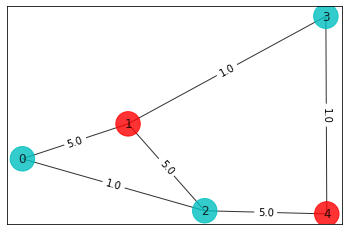

In [3]:
# create minimum eigen optimizer based on VQE
vqe_optimizer = MinimumEigenOptimizer(vqe)

# solve quadratic program
result = vqe_optimizer.solve(qp)
print(result)

colors = ['r' if result.x[i] == 0 else 'c' for i in range(n)]
draw_graph(G, colors, pos)